<a href="https://colab.research.google.com/github/ErrorInever/FacesSpoofRec/blob/main/Class_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf data
!mkdir data
!tar -xvf 'drive/My Drive/datasets/IDRND_FASDB_train.tar.gz' -C data
!tar -xvf 'drive/My Drive/datasets/test.tar.gz' -C data

In [ ]:
!pip install losswise

In [ ]:
%matplotlib inline

import os
import copy
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import losswise
import random
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from torch.utils.data.sampler import SubsetRandomSampler


plt.style.use('ggplot')

def set_seed(val):
    """
    Freezes random sequences
    :param val: ``int`` random value
    """
    random.seed(val)
    np.random.seed(val)
    torch.manual_seed(val)
    torch.cuda.manual_seed(val)
    torch.backends.cudnn.deterministic = True

set_seed(77)

In [ ]:
data_root = 'data'
train_data_path = os.path.join(data_root, 'IDRND_FASDB_train')
test_data_path = os.path.join(data_root, 'test')

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 10

LR = 1e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 0.001
# scheduler
PATIENCE = 2
VERBOSE = True

# Data analysis




In [ ]:
num_train_real_img = len(os.listdir(os.path.join(train_data_path, 'real')))
num_train_spoof_img = len(os.listdir(os.path.join(train_data_path, 'spoof')))
num_test_img = len(os.listdir(test_data_path))

# Remove garbage if exist

In [ ]:
# remove if not img
for cat in os.listdir(train_data_path):
    path = os.path.join(train_data_path, cat)
    try:
        for img in os.listdir(path):
            if not img.endswith(('png', 'jpg')):
                os.remove(os.path.join(path, img))
                print('remove {}'.format(img))
    except NotADirectoryError:
        continue

# rename hidden files
renames = 0
for cat in os.listdir(train_data_path):
    path = os.path.join(train_data_path, cat)
    try:
        for img in os.listdir(path):
            if img.startswith('.'):
                new_name = img[1:]
                os.rename(os.path.join(path, img), os.path.join(path, new_name))
                print('Rename hidden file {} to '.format(img, new_name))
                renames += 1
    except NotADirectoryError:
        continue
print('Rename {} hidden files'.format(renames))

# remove if bad png header
removes = 0
for cat in os.listdir(train_data_path):
    path = os.path.join(train_data_path, cat)
    try:
        for img in os.listdir(path):
            try:
                Image.open(os.path.join(path, img))
            except:
                os.remove(os.path.join(path, img))
                print('Remove bad file {}'.format(os.path.join(path, img)))
                removes += 1
    except NotADirectoryError:
        continue
print('Removes {} files with bad png header'.format(removes))

Rename hidden file ._LTC270_id144_s0_124.png to 
Rename hidden file ._SMG950U_id130_s0_30.png to 
Rename hidden file ._HTCD620_id117_s0_105.png to 
Rename hidden file ._YOUTUBE_id64_s0_45.png to 
Rename hidden file ._SMG950U_id130_s0_15.png to 
Rename hidden file ._LTC270_id144_s0_154.png to 
Rename hidden file ._AA5742_id154_s0_15.png to 
Rename hidden file ._AA5742_id154_s0_112.png to 
Rename hidden file ._SMG950U_id130_s0_77.png to 
Rename hidden file ._AA5742_id154_s0_81.png to 
Rename hidden file ._PBENTE11HC_id153_s0_137.png to 
Rename hidden file ._FT1080P_id165_s0_90.png to 
Rename hidden file ._SMG950U_id130_s0_164.png to 
Rename hidden file ._LTC270_id151_s0_88.png to 
Rename hidden file ._AA5742_id154_s0_62.png to 
Rename hidden file ._AAE5573GP98K_id159_s0_97.png to 
Rename hidden file ._AA5742_id154_s0_96.png to 
Rename hidden file ._PBENTE11HC_id153_s0_107.png to 
Rename hidden file ._REDMI3_id123_s0_75.png to 
Rename hidden file ._LTC270_id144_s0_30.png to 
Rename hidden

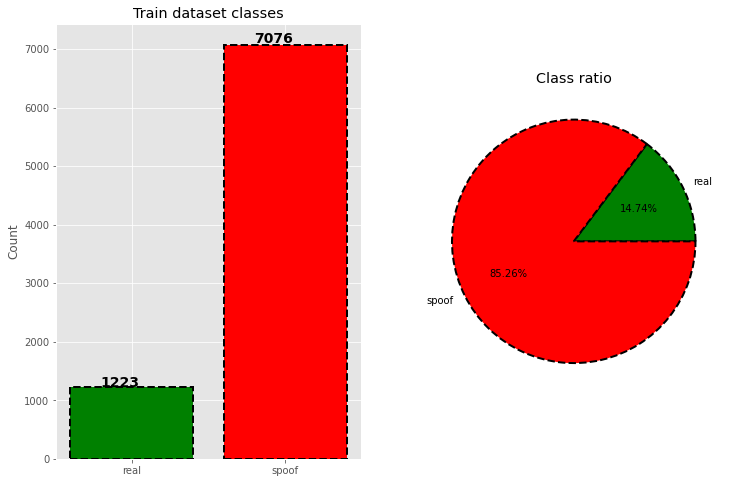

In [ ]:
def plot_hist(num_real_img, num_spoof_img):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
    classes = ['real', 'spoof']
    y = [num_real_img, num_spoof_img]
    ax1.set_title('Train dataset classes')
    ax1.set_ylabel('Count', fontsize=12)
    ax1.bar(classes, y, color=('green', 'red'), edgecolor='black', linewidth=2, linestyle='dashed')
    ax2.set_title('Class ratio')
    ax2.pie(y, labels=classes, autopct='%1.2f%%', colors=('green', 'red'), wedgeprops={"edgecolor":"0",'linewidth': 2,
                                                                                    'linestyle': 'dashed', 'antialiased': True})
    for p in ax1.patches:
        ax1.annotate(str(p.get_height()), (p.get_x() + 0.2, p.get_height() * 1.005), size=14, weight='bold')
    plt.show()

plot_hist(len(os.listdir(os.path.join(train_data_path, 'real'))), len(os.listdir(os.path.join(train_data_path, 'spoof'))))

# Improve dataset

In [ ]:
def over_sampling(path):
    """copy all images and horizontal flip"""
    for img_name in os.listdir(path):
        if not img_name.endswith(('png', 'jpg')):
            continue
        img = cv2.imread(os.path.join(path, img_name))
        copy_img = copy.copy(img)
        fliped_img = cv2.flip(img, 1)
        img_copy_name = '{}_copy.png'.format(img_name.split('.')[:-1][0])
        img_flip_name = '{}_flip.png'.format(img_name.split('.')[:-1][0])

        cv2.imwrite(os.path.join(path, img_copy_name), copy_img)
        cv2.imwrite(os.path.join(path, img_flip_name), fliped_img)

over_sampling(os.path.join(train_data_path, 'real'))

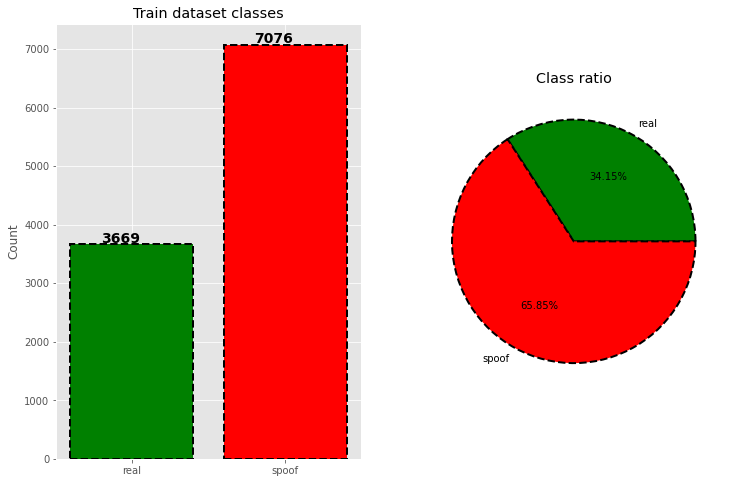

In [ ]:
plot_hist(len(os.listdir(os.path.join(train_data_path, 'real'))), len(os.listdir(os.path.join(train_data_path, 'spoof'))))

In [ ]:
def under_sampling(path, limit):
    """remove img on limit"""
    for img_name in tqdm(os.listdir(path)):
        if limit == 0:
            break
        if not img_name.endswith(('png', 'jpg')):
            continue
        os.remove(os.path.join(path, img_name))
        limit -= 1

limit = len(os.listdir(os.path.join(train_data_path, 'spoof'))) - len(os.listdir(os.path.join(train_data_path, 'real')))
under_sampling(os.path.join(train_data_path, 'spoof'), limit)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


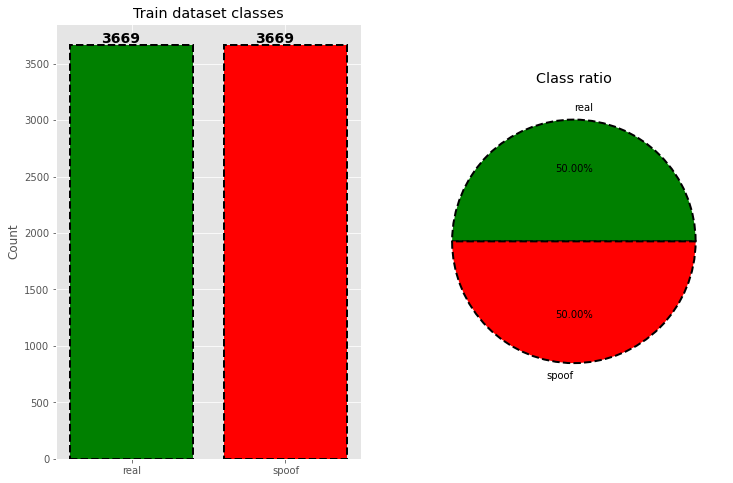

In [ ]:
plot_hist(len(os.listdir(os.path.join(train_data_path, 'real'))), len(os.listdir(os.path.join(train_data_path, 'spoof'))))

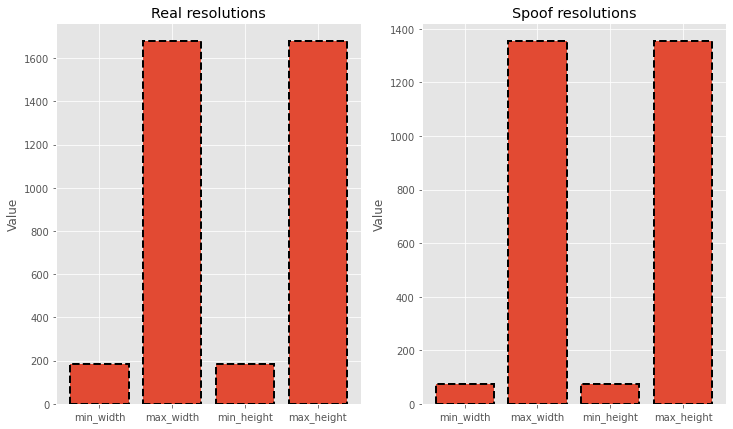

In [ ]:
def check_resolution(dir):
    width_arr = []
    height_arr = []
    for img in os.listdir(dir):
        with Image.open(os.path.join(dir, img)) as img:
            width, height = img.size
            width_arr.append(width)
            height_arr.append(height)
    return [min(width_arr), max(width_arr), min(height_arr), max(height_arr)]

real_res = check_resolution(os.path.join(train_data_path, 'real'))
spoof_res = check_resolution(os.path.join(train_data_path, 'spoof'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
classes = ['min_width', 'max_width', 'min_height', 'max_height']
ax1.set_title('Real resolutions')
ax1.set_ylabel('Value', fontsize=12)
ax1.bar(classes, real_res, edgecolor='black', linewidth=2, linestyle='dashed')
ax2.set_title('Spoof resolutions')
ax2.set_ylabel('Value', fontsize=12)
ax2.bar(classes, spoof_res, edgecolor='black', linewidth=2, linestyle='dashed')
plt.show()

# Define datasets

In [ ]:
class FacesImageFolder(ImageFolder):
  def __getitem__(self, idx):
      sample, target = super().__getitem__(idx)
      path, _ = self.samples[idx]
      target = 0 if 'real' in path else 1
      return sample, target

In [ ]:
def get_indices(dataset_size, seed, value, shuffle=False):
	"""split dataset. gets train, validation and test indices for dataloaders"""
	indices = list(range(dataset_size))
	split = int(np.floor(value * dataset_size))
	if shuffle:
		np.random.seed(seed)
		np.random.shuffle(indices)
	train_ind, val_ind = indices[split:], indices[:split]
	val_ind, test_ind = val_ind[:len(val_ind)//2], val_ind[len(val_ind)//2:]
	return train_ind, val_ind, test_ind

In [ ]:
train_transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize((224, 224)),
                                                  torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
                                                  torchvision.transforms.RandomRotation((-20, 20)),
                                                  torchvision.transforms.ToTensor()])

test_transform = torchvision.transforms.Compose([
                                                 torchvision.transforms.Resize((224, 244)),
                                                 torchvision.transforms.ToTensor()])


train_dataset = FacesImageFolder(train_data_path, transform=train_transform)
test_dataset = FacesImageFolder(train_data_path, transform=test_transform)

# get indices
train_ind, val_ind, test_ind = get_indices(len(train_dataset), 47, .2, shuffle=True)

train_sampler = SubsetRandomSampler(train_ind)
valid_sampler = SubsetRandomSampler(val_ind)
test_sampler = SubsetRandomSampler(test_ind)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

In [ ]:
def show_batch(batch):
    """
    shows images from batch
    :param batch: ``Tensor`` images
    """
    images = batch[0]
    labels = batch[1]
    fig, ax = plt.subplots(1, 10, figsize=(20, 10))

    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).numpy()
        label = labels[i].numpy().squeeze(0)
        label = 'real' if label == 0 else 'spoof'
        ax[i].imshow((img * 255).astype(np.uint8))
        ax[i].axis('off')
        ax[i].set_title(label, fontsize=15, weight='bold')
    plt.show()

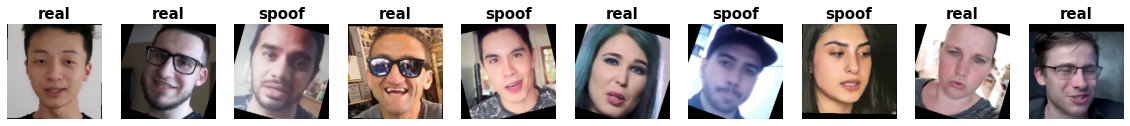

In [ ]:
show_batch(next(iter(train_dataloader)))

In [ ]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(588, 74, 74)

# Normalize

In [ ]:
def compute_mean_std(dataloader):
    """
    Calculate mean and standard deviation of dataset
    :param dataloader: ``generator`` which yield [N, C, H, W] shape
    """
    mean = 0.
    std = 0.
    nb_samples = 0
    for data in tqdm(dataloader, total=len(dataloader)):
        img = data[0]
        batch_samples = img.size(0)
        img = img.view(batch_samples, img.size(1), -1)
        mean += img.mean(2).sum(0)
        std += img.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    print('mean: {}'.format(mean))
    print('std: {}'.format(std))

In [ ]:
#compute_mean_std(train_dataloader)

# Define model

In [ ]:
from torch import nn

def activation_func(activation):
    """
    Gets instance of function
    :param activation: name function
    :return: instance of function
    """
    return nn.ModuleDict([
        ['relu', nn.ReLU(inplace=False)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=False)],
        ['selu', nn.SELU(inplace=False)],
        ['none', nn.Identity()]
    ])[activation]


class DepthwiseSeparableConv(nn.Module):
    """Depthwise Separable Convolution"""
    def __init__(self, in_channels, out_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        # convolve separately each channel of specified kernel
        self.depth_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size,
                                    stride=stride, padding=padding, dilation=dilation, groups=in_channels, bias=bias)
        # increase the number of channels of each feature
        self.pointwise = nn.Conv2d(in_channels=in_channels, out_channels=out_channel, kernel_size=(1, 1),
                                   stride=(1, 1), padding=0, dilation=1, groups=1, bias=False)

    def forward(self, x):
        out = self.depth_conv(x)
        out = self.pointwise(out)
        return out


class Block(nn.Module):
    """Block layer"""
    def __init__(self, in_channels, out_channels, repeats, strides=1, act_type='relu', activation_first=True,
                 grow_first=True):
        super().__init__()

        # define skip connection
        if in_channels != out_channels or strides != 1:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides, bias=False)
            self.skip_bn = nn.BatchNorm2d(out_channels)
        else:
            self.skip_connection = None

        self.activation = activation_func(act_type)

        layers = []
        channels = in_channels

        if grow_first:
            layers.append(self.activation)
            layers.append(DepthwiseSeparableConv(in_channels, out_channels, 3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            channels = out_channels

        for i in range(repeats):
            layers.append(self.activation)
            layers.append(DepthwiseSeparableConv(channels, channels, 3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(channels))

        if not grow_first:
            layers.append(self.activation)
            layers.append(DepthwiseSeparableConv(in_channels, out_channels, 3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))

        if not activation_first:
            layers = layers[1:]
        else:
            layers[0] = activation_func(act_type)

        if strides != 1:
            layers.append(nn.MaxPool2d(3, strides, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)

        if self.skip_connection is not None:
            skip = self.skip_connection(x)
            skip = self.skip_bn(skip)
        else:
            skip = x

        out += skip
        return out


# class Head(nn.Module):
#     """Pre-trained layers on ImageNet from vgg19"""
#     def __init__(self, pretrained=True):
#         super().__init__()
#         features = list(torchvision.models.vgg19(pretrained=pretrained, progress=True).features)[:3]
#         self.features = nn.Sequential(*features)
#
#     def forward(self, x):
#         return self.features(x)


class XrayMRSCNN(nn.Module):
    """Main model"""
    def __init__(self, num_classes=2, act_type='relu'):
        super().__init__()
        self.num_classes = num_classes

        self.head = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.block1 = Block(64, 64, 1, 1, activation_first=False, grow_first=True)
        self.block2 = Block(64, 128, 1, 2, activation_first=True, grow_first=True)
        self.block3 = Block(128, 256, 1, 2, activation_first=True, grow_first=True)
        self.block4 = Block(256, 512, 1, 2, activation_first=True, grow_first=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.15, inplace=False),
            nn.Linear(512, num_classes, bias=True)
        )

        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.head(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Use {}'.format(device))

Use cuda:0


In [ ]:
del model

In [ ]:
model = XrayMRSCNN()
#model = torchvision.models.resnet50(pretrained=True)
#model = torchvision.models.resnet34(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)

In [ ]:
model.to(device)

XrayMRSCNN(
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): Block(
    (activation): ReLU()
    (layers): Sequential(
      (0): DepthwiseSeparableConv(
        (depth_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): DepthwiseSeparableConv(
        (depth_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (4): BatchNorm2d

# Params

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, verbose=VERBOSE)

In [ ]:
class MetricLogger:
	"""Metric helper class"""
	def __init__(self, experiment_name, loss_api_key):
		self.experiment_name = experiment_name
		self.loss_api_key = loss_api_key

		self.epoch_t_loss = []
		self.epoch_t_acc = []
		self.epoch_v_loss = []
		self.epoch_v_acc = []

		if self.loss_api_key:
			losswise.set_api_key(self.loss_api_key)
			self.session = losswise.Session(
					tag=self.experiment_name,
					max_iter=NUM_EPOCHS,
					track_git=False
				)
			self.graph_loss = self.session.graph('loss', kind='min')
			self.graph_acc = self.session.graph('acc', kind='max')

	def log(self, loss, acc, epoch, n_batch, num_batches):
		if isinstance(loss, torch.autograd.Variable):
			loss = loss.item()
		if isinstance(acc, torch.autograd.Variable):
			acc = acc.float().mean().item()

		step = MetricLogger._step(epoch, n_batch, num_batches)

		if self.loss_api_key:
			self.graph_loss.append(step, {'loss': loss})
			self.graph_acc.append(step, {'acc': acc})

	def save_epoch_history(self, t_loss, t_acc, v_loss, v_acc):
		self.epoch_t_loss.append(t_loss)
		self.epoch_t_acc.append(t_acc)
		self.epoch_v_loss.append(v_loss)
		self.epoch_v_acc.append(v_acc)

	def close_session(self):
		self.session.done()

	@staticmethod
	def display_status(epoch, num_epochs, n_batch, num_batches, loss, acc):
		if isinstance(loss, torch.autograd.Variable):
			loss = loss.item()
		if isinstance(acc, torch.autograd.Variable):
			acc = acc.float().mean().item()

		print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(epoch, num_epochs, n_batch, num_batches))
		print('Loss: {:.4f}, Acc: {:.4f}'.format(loss, acc))

	@staticmethod
	def _step(epoch, n_batch, num_batches):
		return epoch * num_batches + n_batch

def metrics(true_labels, pred_labels):

    true_labels = torch.cat(true_labels).numpy()
    pred_labels = torch.cat(pred_labels).numpy()

    cm = confusion_matrix(true_labels, pred_labels)

    try:
        tn, fp, fn, tp = cm.ravel()
    except ValueError:
        cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        
    finally:
        svm = sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', linecolor='black', linewidths=1, cbar=False,
                          xticklabels=['Real', 'Spoof'], yticklabels=['Real', 'Spoof'])
        svm.set(title="Confusion matrix")
        fig = svm.get_figure()
        fig.savefig('confusion_matrix.png', dpi=400)
    try:
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1_score = 2 * (recall * precision) / (precision + recall)

    except ZeroDivisionError:
        logger.exception('ZeroDivisionError, tn:%s, fp:%s, fn:%s, tp:%s', tn, fp, fn, tp)
        recall = None
        precision = None
        f1_score = None

    return recall, precision, f1_score

    
def test_model(model, dataloader, device):
	model.eval()
	test_acc = 0.

	true_labels = []
	pred_labels = []

	for images, labels in tqdm(dataloader, total=len(dataloader)):
		images = images.to(device)
		labels = labels.to(device)

		predict = model(images)
		predict_class = predict.argmax(dim=1)
		test_acc += (predict_class == labels.data).float().mean().item()

		true_labels.append(labels.detach().cpu())
		pred_labels.append(predict_class.detach().cpu())

	test_acc = test_acc / len(dataloader)

	recall, precision, f1_score = metrics(true_labels, pred_labels)

	print('Accuracy: {}\nRecall: {}\nPrecision : {}\nF1-Score : {}'.format(
		round(100 * test_acc, 2),
		round(100 * recall, 2),
		round(100 * precision, 2),
		round(100 * f1_score, 2)))

# Train loop

In [ ]:
def train_one_epoch(model, dataloader, val_dataloader, optimizer, criterion, scheduler, device, epoch, metric_logger, freq=100):
    running_loss = 0.
    running_acc = 0.
    epoch_loss = 0.
    epoch_acc = 0.

    model.train()
    for n_batch, (img, label) in enumerate(dataloader):
        # skip unless it's full batch
        if len(img) != BATCH_SIZE:
            continue
        
        images = img.to(device)
        labels = label.to(device)

        optimizer.zero_grad()
        predict = model(images)
        loss = criterion(predict, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += (predict.argmax(dim=1) == labels.data).float().mean().item()
        epoch_loss += loss.item()
        epoch_acc += (predict.argmax(dim=1) == labels.data).float().mean().item()

        #metrics
        if n_batch % freq == 0 and n_batch != 0:
            with torch.no_grad():
                metric_logger.log(running_loss, running_acc, epoch, n_batch, len(dataloader))
                metric_logger.display_status(epoch, NUM_EPOCHS, n_batch, len(dataloader), running_loss / freq, running_acc / freq)
                running_loss = 0.
                running_acc = 0.
        
    model.eval()
    v_loss = 0.
    v_acc = 0.
    for n_batch, (img, label) in enumerate(val_dataloader):
        images = img.to(device)
        labels = label.to(device)
        predict = model(images)
        loss = criterion(predict, labels)
        v_loss += loss.item()
        v_acc += (predict.argmax(dim=1) == labels.data).float().mean().item()
    
    v_loss = v_loss / len(val_dataloader)
    v_acc = v_acc / len(val_dataloader)
    epoch_loss = epoch_loss / len(dataloader)
    epoch_acc = epoch_acc / len(dataloader)
    metric_logger.save_epoch_history(epoch_loss, epoch_acc, v_loss, v_acc)
    print('Epoch loss: {}, Epoch acc: {}\nVal loss : {}, Val acc: {}\n'.format(
        epoch_loss, epoch_acc, v_loss, v_acc))

Command '['git', 'diff']' returned non-zero exit status 129.
Losswise: choosing optimal display_interval = 1 for "loss" graph.
You may override this default behavior by manually setting display_interval yourself.
Losswise: choosing optimal display_interval = 1 for "acc" graph.
You may override this default behavior by manually setting display_interval yourself.
Epoch: [0/20], Batch Num: [100/588]
Loss: 1.3073, Acc: 0.6110
Epoch: [0/20], Batch Num: [200/588]
Loss: 1.1660, Acc: 0.5820
Epoch: [0/20], Batch Num: [300/588]
Loss: 0.8400, Acc: 0.6420
Epoch: [0/20], Batch Num: [400/588]
Loss: 0.7311, Acc: 0.6740
Epoch: [0/20], Batch Num: [500/588]
Loss: 0.7924, Acc: 0.6400
Epoch loss: 0.9175504787134475, Epoch acc: 0.6345238183580694
Val loss : 0.6486686113718394, Val acc: 0.6220720825163094

Epoch: [1/20], Batch Num: [100/588]
Loss: 0.5823, Acc: 0.7450
Epoch: [1/20], Batch Num: [200/588]
Loss: 0.6192, Acc: 0.6890
Epoch: [1/20], Batch Num: [300/588]
Loss: 0.5854, Acc: 0.7340
Epoch: [1/20], Bat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy: 96.76
Recall: 94.31
Precision : 99.15
F1-Score : 96.67
Training time 3129.9711532592773


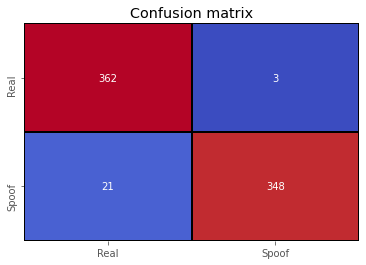

In [ ]:
NUM_EPOCHS = 20
logger = MetricLogger('Xray_20_epoch', 'KACT4O1Z2')
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_one_epoch(model, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device, epoch, logger, freq=100)

test_model(model, test_dataloader, device)
logger.close_session()
total_time = time.time() - start_time
print('Training time {}'.format(total_time))

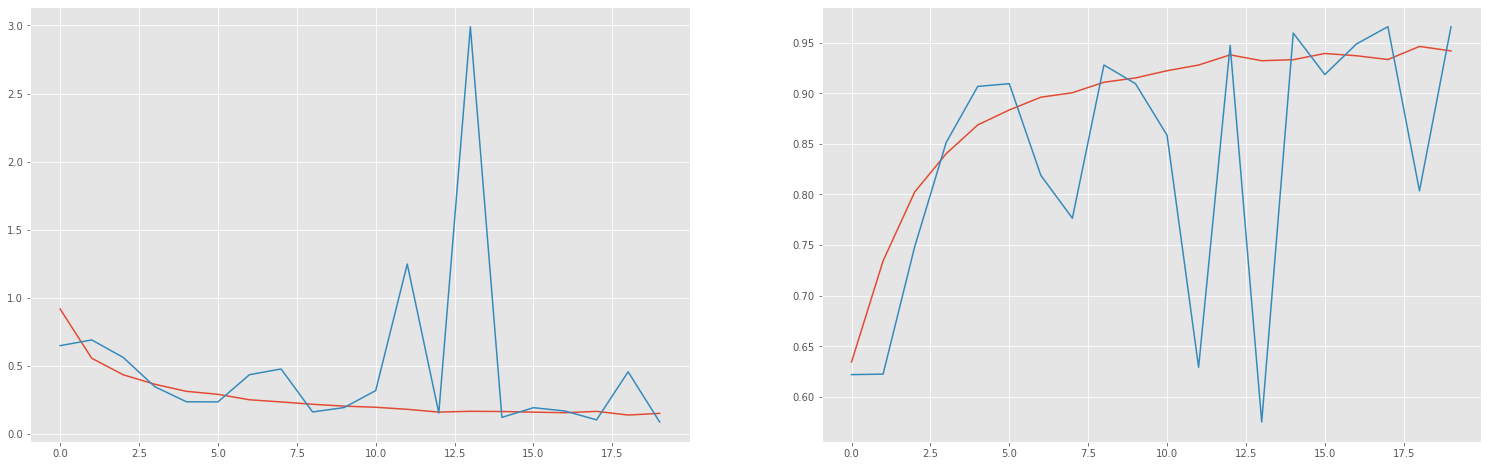

In [ ]:
t_loss = logger.epoch_t_loss
t_acc = logger.epoch_t_acc
v_loss = logger.epoch_v_loss
v_acc = logger.epoch_v_acc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 8))
ax1.plot(range(NUM_EPOCHS), t_loss)
ax1.plot(range(NUM_EPOCHS), v_loss)
ax2.plot(range(NUM_EPOCHS), t_acc)
ax2.plot(range(NUM_EPOCHS), v_acc)

# Inference

In [ ]:
def show_result(img, pred_class, prob):
    """
    Shows predicted scores on current image
    :param img: ``Tensor`` image
    :param pred_class: ``str`` predicted class
    :param prob: ``float`` predicted probability
    """
    img = img.detach().cpu().squeeze(0).permute(1, 2, 0)
    plt.axis('off')
    plt.imshow(img)
    plt.title('Predicted class: {}\nProbability: {}%'.format(pred_class, round(prob, 1)))
    plt.savefig('result.png', bbox_inches='tight')
    plt.show()

In [ ]:
import torch.nn.functional as F

def inference(model, path, device):
    model.eval()
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor()]
    )
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        try:
            img = transform(img).unsqueeze(0)
        except TypeError:
            print('Incorrect image path or image type')
            continue
        model.eval()
        with torch.no_grad():
            img = img.to(device)
            predict = model.inference(img)
        #probs = F.softmax(F.softmax(predict, dim=1), dim=1)
        probs = predict
        real_prob = probs[0][0]
        label = predict.data.argmax()
        pred_class = 'Real' if label.item() == 0 else 'Spoof'
        print('Real prob: {}, Probs {}, Predicted class {}'.format(real_prob, probs, pred_class))

        with open('test', 'a') as the_file:
            the_file.write('{},{}\n'.format(img_name, real_prob))


In [ ]:
inference(model, 'data/test', device)

Streaming output truncated to the last 5000 lines.
Real prob: 0.011117896996438503, Probs tensor([[0.0111, 0.9889]], device='cuda:0'), Predicted class Spoof
Real prob: 0.9704924821853638, Probs tensor([[0.9705, 0.0295]], device='cuda:0'), Predicted class Real
Real prob: 0.9999643564224243, Probs tensor([[9.9996e-01, 3.5685e-05]], device='cuda:0'), Predicted class Real
Real prob: 0.9033306241035461, Probs tensor([[0.9033, 0.0967]], device='cuda:0'), Predicted class Real
Real prob: 0.18719781935214996, Probs tensor([[0.1872, 0.8128]], device='cuda:0'), Predicted class Spoof
Real prob: 0.006455921567976475, Probs tensor([[0.0065, 0.9935]], device='cuda:0'), Predicted class Spoof
Real prob: 0.01558450236916542, Probs tensor([[0.0156, 0.9844]], device='cuda:0'), Predicted class Spoof
Real prob: 0.002756682224571705, Probs tensor([[0.0028, 0.9972]], device='cuda:0'), Predicted class Spoof
Real prob: 0.5989111065864563, Probs tensor([[0.5989, 0.4011]], device='cuda:0'), Predicted class Real
R